# Introduction

This notebook is a continuation of the notebook from the milestone 2, however, we are now using a much bigger dataset (originally, we used 111'000 reviews, this notebook is the result with 18'000'000 reviews)

# Import/Helpers

In [1]:
import os
import findspark
findspark.init()
from pyspark import SQLContext, SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics as S
import json
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#compute correlation
def correlation(df, col1, col2, method='pearson'):
    rdd1 = df.select(col1).rdd.map(lambda x: x[0])
    rdd2 = df.select(col2).rdd.map(lambda x: x[0])
    return S.corr(rdd1, rdd2, method)

Creation of a Spark context.

In [3]:
memory = '2g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
sc = SparkContext()
sqlContext = SQLContext(sc)

# Data Preprocessing

We load the data from the json file and rewrite it in parquet format.

The original data should be located at 'datasets/data.json' for the reviews and 'datasets/metadata.json' for the metada, this can of course be changed.

The following code needs only to be ran once.

In [ ]:
# No need to run it, already saved the .parquet.
df_review = sqlContext.read.json("datasets/data.json")

The two following methods alter the structure of the Amazon's product metadata and review in order to make it more easy to work on it later on.

We filter the salesRank to have only ranked products. There is two possiblity, either the salesRank is completely none, either the categories are all None. we take care of both cases.

In [ ]:
# No need to run it, already saved the .parquet.

# We flatten the meta dataframe
def flatten(salesRank):
    if salesRank == None:
        return None, None
    else:
        for category, rank in salesRank.asDict().items():
            if rank != None:
                return (category, rank)
    return None, None
flatten = udf(flatten, StructType([StructField("category", StringType()), StructField("rank", IntegerType())]))
df_flattened = meta_df.withColumn("salesRank", flatten("salesRank"))
df_flattened = df_flattened.drop("_corrupt_record")
df_flattened = df_flattened.select(list(set(df_flattened.schema.names) - set(["salesRank", "related"]))+ ["salesRank.*", "related.*"])
df_flattened.write.parquet("metadata.parquet")

In [ ]:
# No need to run it, already saved the .parquet.

# We check that there is no metadata with two ranks
def not_one_or_none(salesRank):
    count = 0
    # If no rank, then false
    if salesRank == None:
        return 0
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return int(count != 1 and count != 0)
not_one_or_none = udf(not_one_or_none, IntegerType())
not_one_or_none = meta_df.withColumn("exactly_one", not_one_or_none("salesRank")).agg(F.sum("exactly_one").alias("sum")).head()[0]
print("There is %.d article with not exactly one category for a rank"%not_one_or_none)

In [ ]:
df_review.write.parquet("data.parquet")

# Data loading

Here we load the metadata and data review.

In [4]:
df_review = sqlContext.read.parquet("data.parquet")
num_reviews = df_review.count()
num_reviews

18186733

In [5]:
#this must be run.

meta_df = sqlContext.read.parquet("metadata.parquet")

Compute the total number of products.

In [6]:
total_products = meta_df.count()
total_products

9430088

# General data exploration
## Missing data

In [50]:
def print_missing_percentage(df, col, total):
    """Simple method that print the missing
       percentage of column in the dataframe"""
    col_count = df.dropna(subset=[col]).count()
    print("There is %.3f%% of the data with the column %s"%(col_count/total*100, col))

We will now find what percentage of the data is present for some features of the metada that will be used later to contrast the analysis.

In [52]:
for col in ['categories', 'brand', 'category', 'rank', 'also_viewed', 'bought_together', 'buy_after_viewing']:
    print_missing_percentage(meta_df, col, total_products)

There is 88.376% of the data with the column categories
There is 16.738% of the data with the column brand
There is 65.234% of the data with the column category
There is 65.234% of the data with the column rank
There is 37.656% of the data with the column also_viewed
There is 26.481% of the data with the column bought_together
There is 24.045% of the data with the column buy_after_viewing


Same for the reviews

In [51]:
for col in ['asin', 'reviewerID', 'helpful', 'overall', 'reviewText']:
    print_missing_percentage(df_review, col, num_reviews)

There is 100.000% of the data with the column asin
There is 100.000% of the data with the column reviewerID
There is 100.000% of the data with the column helpful
There is 100.000% of the data with the column overall
There is 100.000% of the data with the column reviewText


## Basic statistics

In [40]:
print("There is %d reviews."%df_review.count())
print("There is %d unique products reviewed."%df_review.select("asin").distinct().count())
print("There is %d unique reviewers."%df_review.select("reviewerId").distinct().count())

There is 18186733 reviews.
There is 731283 unique products reviewed.
There is 1116318 unique reviewers.


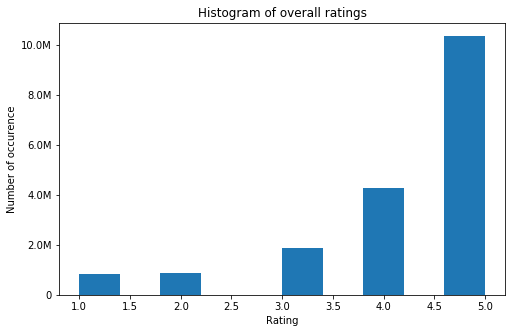

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review.select("overall"))
ax.set_title("Histogram of overall ratings")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of occurence");

The histogram shows that most reviews are positive or neutral.

## Part 1: Reviews Feature

The first part of the analysis is dedicated to studying Amazon's reviews feature.

As a first step, we explore some metrics related to reviews: a quantitative one - the number of words per review - and a qualitative one - the helpfulness of a review. 

### Word count

The wordcount is a metric measuring the length of reviews.

In [8]:
wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

df_review = df_review.withColumn('wordcount', wordCount(df_review["reviewText"]))
df_review.select("wordcount").describe().show()
overall = df_review.select("overall").rdd.map(lambda x: x[0])
wordcount = df_review.select("wordcount").rdd.map(lambda x: x[0])
pearson_corr = correlation(df_review, "overall", "wordcount", method='pearson')
spearman_corr = correlation(df_review, "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

+-------+------------------+
|summary|         wordcount|
+-------+------------------+
|  count|          18186733|
|   mean| 134.3130121831117|
| stddev|171.91125779517296|
|    min|                 1|
|    max|              6465|
+-------+------------------+

The pearson correlation is -0.062 and the spearman is -0.129


It can be noted the correlation between review rating and length is very low.

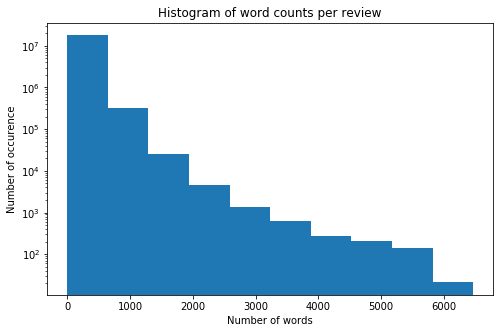

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review.select("wordcount"), log=True)
ax.set_title("Histogram of word counts per review")
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of occurence");

It seems that in average reviews are short (< 1000 words).

### Helpfulness

The helpfulness is a metric measuring the uselfulness of reviews.

We get the helpfulness of a review by computing the ratio of people that found a review helpful and those that voted. If we have no data, we simply put -1 as a ratio.

In [7]:
df_review = df_review.withColumn("helpfulness", F.when(df_review.helpful.getField(1) > 0, df_review.helpful.getField(0)/df_review.helpful.getField(1)).otherwise(-1))
df_review_helpfulness = df_review.filter(df_review["helpfulness"] > 0.0)

In [10]:
df_review_helpfulness.select("helpfulness").describe().show()

+-------+--------------------+
|summary|         helpfulness|
+-------+--------------------+
|  count|             8253665|
|   mean|   0.822555755009797|
| stddev|  0.2395958352831585|
|    min|0.003460207612456...|
|    max|                 8.0|
+-------+--------------------+



There seems to have some discrepancies amongst the ratio, since the max is at 8.0. We will check that it does not occur too often and may drop the data in the future.

In [8]:
df_review_outliers = df_review_helpfulness.filter(df_review["helpfulness"] > 1.0)

df_review_helpfulness = df_review_helpfulness.filter(df_review["helpfulness"] <= 1.0)

df_review_outliers.select("helpful").count()

25

Since only 25 reviews have problems, we will simply filter them out.

We then look at some distribution of helpfulness and rating.

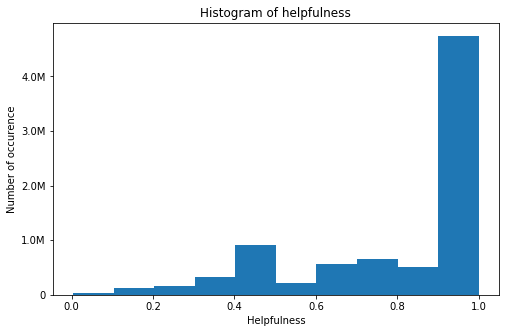

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review_helpfulness.select("helpfulness"))
ax.set_title("Histogram of helpfulness")
ax.set_xlabel("Helpfulness")
ax.set_ylabel("Number of occurence");

In general the helpfulness is very high - between 0.9 and 1. Maybe people generally vote only if the review was helpful?

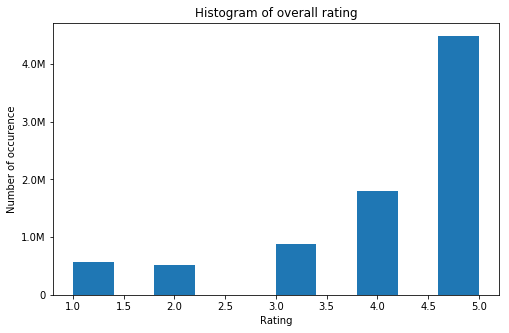

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review_helpfulness.select("overall"))
ax.set_title("Histogram of overall rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of occurence");

Here we compute correlation between the review's rating of the product and the review helpfulness.

In [14]:
df_review_helpfulness.select("overall", "helpfulness").toPandas().corr(method = 'spearman')

,overall,helpfulness
overall,1.00000,0.29288
helpfulness,0.29288,1.00000


Here we compute the correlation between a product ranking and -respectively - the number of reviews it has, the average of the reviews helpfulness, the average of the reviews rating.

In [24]:
output_df = meta_df[['asin', 'rank']]

joined_df = meta_df.join(df_review, 'asin')
grouped_df = joined_df.groupBy('asin')

review_count_df = grouped_df.count()
mean_helpfulness_df = grouped_df.mean('helpfulness', 'overall')
output_df = output_df.join(review_count_df, 'asin').join(mean_helpfulness_df, 'asin')
rank_count_correlation = output_df.corr('rank', 'count', method='pearson')
rank_helpfulness_correlation = output_df.corr('rank', 'avg(helpfulness)', method='pearson')
rank_overall_correlation = output_df.corr('rank', 'avg(overall)', method='pearson')
print(rank_count_correlation, rank_helpfulness_correlation, rank_overall_correlation)

-0.03279435475548705 0.10355802500411362 -0.02118792947357656


With these three correlations we aren't able to draw any meaningful conclusion.

We also try to find some link between helpfulness and word counts.
We will first make a scatterplot of helpfulness and wordcount to see if there is some visual link, then we look at the correlation.

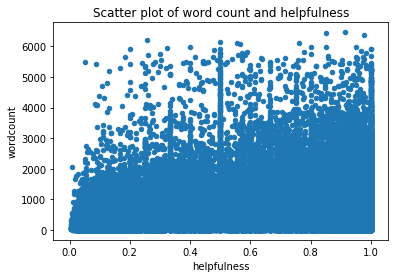

In [32]:
ax = df_review_helpfulness.select("helpfulness", "wordcount").toPandas().plot.scatter("helpfulness", "wordcount")
ax.set_title("Scatter plot of word count and helpfulness")

In [33]:
spearman_corr = df_review_helpfulness.select("helpfulness", "wordcount").toPandas().corr(method = "spearman")
spearman_corr

,helpfulness,wordcount
helpfulness,1.000000,-0.040743
wordcount,-0.040743,1.000000


Unfortunately, there is no obvious link between those two variables.

## influence of reviewer personality

We get the count of review of distinct article per reviewer.

In [7]:
df_count = df_review.groupBy("reviewerID").agg(F.countDistinct("asin").alias('review_count'))

In [8]:
df_count.select("review_count").describe().show()

+-------+------------------+
|summary|      review_count|
+-------+------------------+
|  count|           1116318|
|   mean|15.324043865636853|
| stddev|49.567085362171255|
|    min|                 5|
|    max|             23223|
+-------+------------------+



Since there is some outliers, we only put in our histrogram the values below the 99th percentile.

In [90]:
quantile_99 = df_count.approxQuantile("review_count", [0.99], 0)
quantile_99

[131.0]

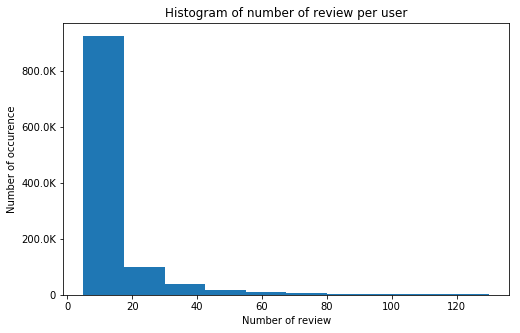

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_count.filter(df_count["review_count"] < 131).select("review_count"))
ax.set_title('Histogram of number of review per user')
ax.set_xlabel('Number of review')
ax.set_ylabel("Number of occurence");

We compute the average grade for each reviewer.

In [28]:
stats_df = df_review.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
stats_df.cache().count()

1116318

Here are some statistic concerning the average grade for each reviewer.

The first row contains the total number of reviewer considered.

The second row contains the mean of the reviewers' averages grades (left) and the standard deviation of said mean (right).

The third row contains the mean of the reviewers' standard deviations (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's lower grades (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's higher grades (left) and the standard deviation of said mean (right).

In [27]:
stats_df.select("mean", "std").describe().show()

+-------+-----------------+------------------+
|summary|             mean|               std|
+-------+-----------------+------------------+
|  count|          1116318|           1116318|
|   mean|4.237445234962941|0.8689434742290474|
| stddev|0.643015213613999|0.5406193821169274|
|    min|              1.0|               0.0|
|    max|              5.0|2.1908902300206647|
+-------+-----------------+------------------+



We then plot the average grade for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such mean ranking on the y-axis.

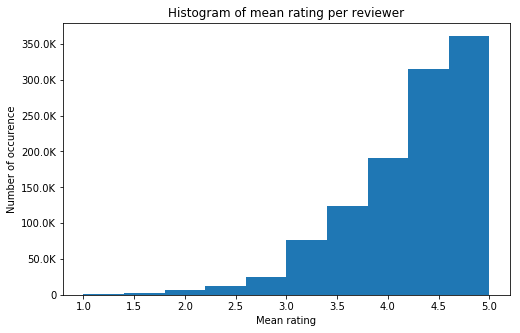

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, stats_df.select("mean"))
ax.set_title("Histogram of mean rating per reviewer")
ax.set_xlabel("Mean rating")
ax.set_ylabel("Number of occurence");

It can be noted that reviewers tend to give high ratings.

We then plot the average standard deviation for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such average standard deviation on the y-axis.

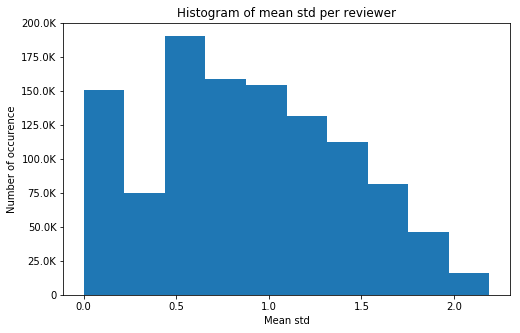

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, stats_df.select("std"))
ax.set_title("Histogram of mean std per reviewer")
ax.set_xlabel("Mean std")
ax.set_ylabel("Number of occurence");

It can be noted that the majority of reviewers tend to have either a very small standard deviation (0-0.25) or a standard deviation between 0.5 and 1.5. The number of people with an higher standard deviation are sensibily less.

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 13.72% of reviewer with std < 0.25


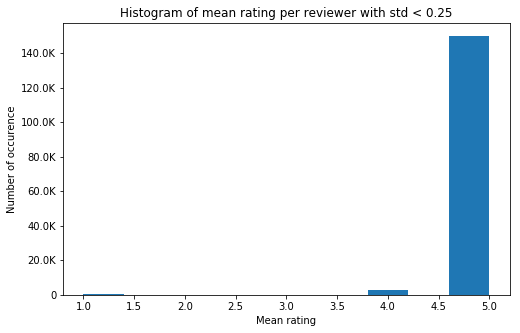

In [34]:
print("There is %.2f%% of reviewer with std < 0.25"%(stats_df.filter(stats_df.std < 0.25).count()/stats_df.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, stats_df.filter(stats_df.std < 0.25).select("mean"))
ax.set_title("Histogram of mean rating per reviewer with std < 0.25")
ax.set_xlabel("Mean rating")
ax.set_ylabel("Number of occurence");

It can be noted that people with a small standard deviation, i.e. people who tend to always give the same rating, tend to give only very high rating (>4.5).

In conclusion, we have hints that there's a certain bias related to reviewers' personality and habits. 
The fact that the mean of the average reviewer rating is so high for example could make us think that people tend to rate the product they're satisfied with and not those they're unsastisfied with.
The fact that the reviewers with little standard deviation tend to give high ratings also speaks in that direction.

## brand fidelity/hate

We load the metadata datas and only keep the article number and the brand that are not null, since we are interested in brands.

We then join the dataframe of reviews with the metadata and display some stats.

In [11]:
# df_meta = sqlContext.read.json("meta_auto_baby_grocery.json")
df_meta_brand = meta_df.select("asin", "brand").dropna()

df_with_brand = df_review.join(df_meta_brand, on='asin')
num_reviews_with_brand = df_with_brand.count()

print("We have %.d, which represents %.3f%% of review with a brand and who belongs to reviewer with 5 or more reviews"%(num_reviews_with_brand, num_reviews_with_brand/num_reviews*100))
print("We have %.3f%% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand "%(num_reviews_with_brand/num_five_reviews*100))

We have 3195304, which represents 17.569% of review with a brand and who belongs to reviewer with 5 or more reviews
We have 17.569% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand 


We can see that once again we loose a lot of reviews with this approach, but it is still an interesting number to work with.

Then we group by brand and reviewer, compute some stats and filter out all reviewers that have less than 5 reviews for a specific brand.

In [12]:
df_brand_reviewer = df_with_brand.groupBy(["brand", "reviewerID"]).agg(F.count("overall").alias("count"), F.avg("overall").alias("mean"), F.stddev("overall").alias("std")).filter("`count` >= 5")
brand_reviewers_count = df_brand_reviewer.cache().count()
print("We have %.d brand/reviewers tuples"%(brand_reviewers_count))

We have 27991 brand/reviewers tuples


We then show some stats about the mean and std.

+-------+------------------+-----------------+------------------+
|summary|             count|             mean|               std|
+-------+------------------+-----------------+------------------+
|  count|             27991|            27991|             27991|
|   mean|10.549819584866563|4.285022974122227|0.7416057878513868|
| stddev| 18.57718396527397|0.645902890517677|0.5229705628819817|
|    min|                 5|              1.0|               0.0|
|    max|               794|              5.0|2.1908902300206647|
+-------+------------------+-----------------+------------------+



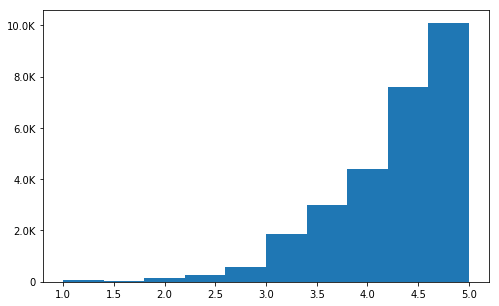

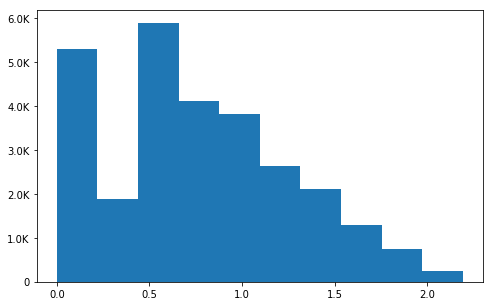

In [13]:
df_brand_reviewer.select("count", "mean", "std").describe().show()
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("mean"));
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("std"));

By comparing qualitatively those graphs with the one from Question 2, we can see that the ratings seems to be having less deviation, showing a tendency to love/hate toward a brand.

We try to see if there is an obvious correlation between number of reviews for a brand and the mean rate:

In [14]:
pearson_corr = correlation(df_brand_reviewer, "count", "mean", method='pearson')
spearman_corr = correlation(df_brand_reviewer, "count", "mean", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

The pearson correlation is -0.050 and the spearman is -0.116


These correlation aren't meaningful.

## Part 2: advertising features

This function allows to explode a column whose data type is a structure in a dataframe.

In [135]:
def explode_and_join(column_to_explode):
    q4_meta_df = meta_df.select("asin", "rank", F.explode(column_to_explode).alias("paired_product")).dropna(how='any')
    q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias("paired_asin"), F.col("rank").alias("paired_rank")), F.col("paired_product") == F.col("paired_asin"), "inner")
    return q4_joined_meta_df

This function explodes two columns of a dataframe.

In [136]:
def explode_and_join_tuple(column_to_explode_1, alias_1, column_to_explode_2, alias_2):
    q4_meta_df = meta_df.select("asin", "rank", alias_2, F.explode(column_to_explode_1).alias(alias_1)).dropna(how='any')
    q4_meta_df = q4_meta_df.select("asin", "rank", alias_1, F.explode(column_to_explode_2).alias(alias_2)).dropna(how='any')
    q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias(alias_1 + "_asin"), F.col("rank").alias(alias_1 + "_rank")), F.col(alias_1) == F.col(alias_1 + "_asin"), "inner").dropna(how='any')
    q4_joined_meta_df = q4_joined_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias(alias_2 + "_asin"), F.col("rank").alias(alias_2 + "_rank")), F.col(alias_2) == F.col(alias_2 + "_asin"), "inner").dropna(how='any')
    #q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias("paired_asin"), F.col("rank").alias("paired_rank")), F.col("paired_product") == F.col("paired_asin"), "inner")
    return q4_joined_meta_df.limit(1000)

As a first thing, we explode the 'bought together' column of the dataframe. Each row of the resulting dataframe will have too product ranking: "rank", which is the rank of the original product, and "paired rank", which is the rank of o product which was bought together with the original.

In [137]:
bought_together_df = explode_and_join("bought_together")

Following this, we plot the "rank" and "paired_rank".

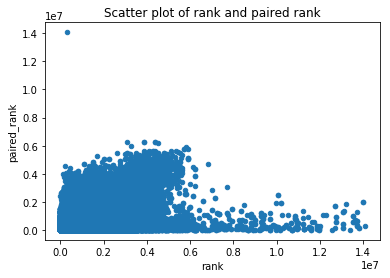

In [38]:
ax = bought_together_df.toPandas().plot.scatter("rank", "paired_rank")
# ax.set_xlim(0, 1000000)
# ax.set_ylim(0, 1000000)
ax.set_title("Scatter plot of rank and paired rank");

Then compute their Spearman correlation.

In [138]:
from scipy.stats import spearmanr
df = bought_together_df.select('rank', 'paired_rank').toPandas()
spearmanr(df['rank'], df['paired_rank'])

SpearmanrResult(correlation=0.5644786356133229, pvalue=0.0)

In [35]:
rank_bought_together_correlation = bought_together_df.select('rank', 'paired_rank').toPandas().corr( method='spearman')
rank_bought_together_correlation

,rank,paired_rank
rank,1.000000,0.564479
paired_rank,0.564479,1.000000


The Spearman correlation has a remarkable value.

We do the same with the 'also_bought' feature.

In [36]:
also_bought_df = explode_and_join("also_bought")

And compute its correlation.

In [37]:
rank_also_bought_correlation = also_bought_df.corr('rank', 'paired_rank', method='pearson')
rank_also_bought_correlation

0.4513344392636174

This correlation is too weak to be meaningful.

We do the same with the 'also_viewed' feature.

In [40]:
also_viewed_df = explode_and_join("also_viewed")

In [41]:
rank_also_viewed_correlation = also_viewed_df.corr('rank', 'paired_rank', method='pearson')
rank_also_viewed_correlation

0.10400314137543323

This correlation is too weak to be meaningful.

In [13]:
# tuple_df = explode_and_join_tuple("also_bought", "also_bought", "bought_together", "bought_together")

# also_bought_bought_together_correlation = tuple_df.select("also_bought", "bought_together").toPandas().corr(method = 'spearman')

# also_bought_bought_together_correlation

# tuple_df = explode_and_join_tuple("also_bought", "also_bought", "also_viewed", "also_viewed")

# also_bought_also_viewed_correlation = tuple_df.select("also_bought", "also_viewed").toPandas().corr(method = 'spearman')

# print(also_bought_bought_together_correlation, also_bought_also_viewed_correlation)

Here we tried to explode two columns of the dataset to compute the intra advertising feature correlation. However, due to the exponential compelexity of the operation, we failed.

## Question 6: product categorization

Here we divise the products per category and computet the number of review, average helpfulness of the reviews and average rating of the reviews per category.

In [122]:
def explode_categories():
    q6_meta_df = meta_df.select("asin", "rank", F.explode("categories").alias("category")).select("asin", "rank", F.explode("category").alias("category")).dropna(how='any')
    review_count_per_category = q6_meta_df.join(df_review_helpfulness, "asin").groupby("category")\
        .agg(F.count("asin").alias("num_reviews"),\
             F.countDistinct("asin").alias("num_products"),\
             F.avg("helpfulness"),\
             F.mean("overall"))
    review_count_per_category = review_count_per_category.orderBy("num_reviews", ascending = False)
    return review_count_per_category
    
review_count_per_category = explode_categories()
review_count_per_category.count()

6678

The we compute some statistics.

In [109]:
review_count_per_category.describe().show()

+-------+--------+------------------+-----------------+-------------------+------------------+
|summary|category|       num_reviews|     num_products|   avg(helpfulness)|      avg(overall)|
+-------+--------+------------------+-----------------+-------------------+------------------+
|  count|    6678|              6678|             6678|               6678|              6678|
|   mean|    null|2073.9144953578916|177.7395926924229| 0.8708999992861884|4.1894200454996255|
| stddev|    null| 42300.27890626757|2842.843360606542|0.08031026500821586|0.4556422371234701|
|    min| #508510|                 1|                1| 0.3333333333333333|               1.0|
|    max| pediped|           2571076|           209707|                1.0|               5.0|
+-------+--------+------------------+-----------------+-------------------+------------------+



It can be noted that the average helpfulness is high (0.9) and the average overall rating too (4.00).

In [49]:
correlation1 = review_count_per_category.select('avg(helpfulness)', 'avg(overall)').toPandas().corr(method = 'spearman')
correlation1

,avg(helpfulness),avg(overall)
avg(helpfulness),1.000000,0.138791
avg(overall),0.138791,1.000000


There's a very weak correlation between average helpfulness and average overall rating.

In [107]:
correlation2 = review_count_per_category.select('avg(helpfulness)', 'num_reviews').toPandas().corr(method = 'spearman')
correlation2

,avg(helpfulness),num_reviews
avg(helpfulness),1.000000,-0.202871
num_reviews,-0.202871,1.000000


there's a weak negative correlation between the average helpfulness of reviews and the number of review associated to a category.

In [108]:
correlation3 = review_count_per_category.select('avg(overall)', 'num_reviews').toPandas().corr(method = 'spearman')
correlation3

,avg(overall),num_reviews
avg(overall),1.00000,-0.13671
num_reviews,-0.13671,1.00000


There's a barely noticeable correlation between the overall rating and the number of reviews.

If we take into account the categories where the product is ranked:

In [123]:
meta_df_per_category = meta_df.select("asin", "rank", "category", "price").dropna(how='any')\
    .join(df_review_helpfulness, "asin")\
    .groupby("category")\
    .agg(F.count("asin").alias("num_reviews"),\
         F.countDistinct("asin").alias("num_products"),\
         F.avg("helpfulness"),\
         F.mean("overall"))

In [124]:
meta_df_per_category.select('avg(helpfulness)', 'avg(overall)').toPandas().corr(method = 'spearman')

,avg(helpfulness),avg(overall)
avg(helpfulness),1.000000,0.409566
avg(overall),0.409566,1.000000


There's a slightly less weak correlation between average helpfulness and average overall rating, again.

In [125]:
meta_df_per_category.select('avg(helpfulness)', 'num_reviews').toPandas().corr(method = 'spearman')

,avg(helpfulness),num_reviews
avg(helpfulness),1.000000,-0.352169
num_reviews,-0.352169,1.000000


there's a remarkable negative correlation between the average helpfulness of reviews and the number of review associated to a category.

In [126]:
meta_df_per_category.select('avg(overall)', 'num_reviews').toPandas().corr(method = 'spearman')

,avg(overall),num_reviews
avg(overall),1.000000,-0.099444
num_reviews,-0.099444,1.000000


There's a barely noticeable correlation between the overall rating and the number of reviews.